In [1]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [2]:
import torch
from torch import nn
import torchaudio

import sys
sys.path.append('/kaggle/input/sd-helper')
from SD_utils import batch_pit_loss
from custom_SA_EEND import SA_EEND
#from AMI import AMI
from HF_DiDataset import DiarizationDataset
import S4T as S

In [3]:
from typing import Optional
import os
import collections

class AMI(torch.utils.data.Dataset):
    def __init__(self,
                 subset: str,
                 media_stream: str,
                 audio_directory: Optional[str] = None,
                 annotation_directory: Optional[str] = None,
                 default_directory: str = './'):
        super().__init__()
        self.subset = subset
        self.media_stream = media_stream
        self.audio_dir = audio_directory
        self.ann_dir = annotation_directory
        self.default_dir = default_directory
        self.data = os.listdir(self.ann_dir)

    def __getitem__(self, idx):
        sample = {'timestamps_start': [],
                  'timestamps_end': [],
                  'speakers': []}
        with open(os.path.join(self.ann_dir, self.data[idx]), 'r') as f:
            for line in f.readlines():
                seg_type, file_id, channel_id, start, length, _, _, speaker, _, _ = line.split(' ')
                sample['timestamps_start'].append(float(start))
                sample['timestamps_end'].append(float(start) + float(length))
                sample['speakers'].append(speaker)
        sample['file_id'] = file_id
        return sample
    
    def __len__(self):
        return len(self.data)

In [4]:
from typing import Optional, Callable

import torch
import numpy as np
import librosa

def stft(data: np.array,
         win_length: int = 1024,
         hop_length: int = 256):
    """
    Compute STFT features
    data: np.array, shape (n_samples, )

    Returns:
    """
    # round up to nearest power of 2
    fft_size = 1 << (win_length - 1).bit_length()
    if len(data) % win_length == 0:
        return librosa.stft(data, n_fft = fft_size, win_length = win_length, hop_length = hop_length).T[:-1]
    else:
        return librosa.stft(data, n_fft = fft_size, win_length = win_length, hop_length = hop_length).T

def transform(
        Y,
        transform_type=None,
        dtype=np.float32):
    """ Transform STFT feature

    Args:
        Y: STFT
            (n_frames, n_bins)-shaped np.complex array
        transform_type:
            None, "log"
        dtype: output data type
            np.float32 is expected
    Returns:
        Y (numpy.array): transformed feature
    """
    Y = np.abs(Y)
    if not transform_type:
        pass
    elif transform_type == 'log':
        Y = np.log(np.maximum(Y, 1e-10))
    elif transform_type == 'logmel':
        n_fft = 2 * (Y.shape[1] - 1)
        sr = 16000
        n_mels = 40
        mel_basis = librosa.filters.mel(sr = sr, 
                                        n_fft = n_fft, 
                                        n_mels = n_mels)
        Y = np.dot(Y ** 2, mel_basis.T)
        Y = np.log10(np.maximum(Y, 1e-10))
    elif transform_type == 'logmel23':
        n_fft = 2 * (Y.shape[1] - 1)
        sr = 8000
        n_mels = 23
        mel_basis = librosa.filters.mel(sr = sr, 
                                        n_fft = n_fft, 
                                        n_mels = n_mels)
        Y = np.dot(Y ** 2, mel_basis.T)
        Y = np.log10(np.maximum(Y, 1e-10))
    elif transform_type == 'logmel23_mn':
        n_fft = 2 * (Y.shape[1] - 1)
        sr = 8000
        n_mels = 23
        mel_basis = librosa.filters.mel(sr = sr, 
                                        n_fft = n_fft, 
                                        n_mels = n_mels)
        Y = np.dot(Y ** 2, mel_basis.T)
        Y = np.log10(np.maximum(Y, 1e-10))
        mean = np.mean(Y, axis=0)
        Y = Y - mean
    elif transform_type == 'logmel23_swn':
        n_fft = 2 * (Y.shape[1] - 1)
        sr = 8000
        n_mels = 23
        mel_basis = librosa.filters.mel(sr = sr, 
                                        n_fft = n_fft, 
                                        n_mels = n_mels)
        Y = np.dot(Y ** 2, mel_basis.T)
        Y = np.log10(np.maximum(Y, 1e-10))
        # b = np.ones(300)/300
        # mean = scipy.signal.convolve2d(Y, b[:, None], mode='same')

        #  simple 2-means based threshoding for mean calculation
        powers = np.sum(Y, axis=1)
        th = (np.max(powers) + np.min(powers)) / 2.0
        for i in range(10):
            th = (np.mean(powers[powers >= th]) + np.mean(powers[powers < th])) / 2
        mean = np.mean(Y[powers > th, :], axis=0)
        Y = Y - mean
    elif transform_type == 'logmel23_mvn':
        n_fft = 2 * (Y.shape[1] - 1)
        sr = 8000
        n_mels = 23
        mel_basis = librosa.filters.mel(sr = sr, 
                                        n_fft = n_fft, 
                                        n_mels = n_mels)
        Y = np.dot(Y ** 2, mel_basis.T)
        Y = np.log10(np.maximum(Y, 1e-10))
        mean = np.mean(Y, axis=0)
        Y = Y - mean
        std = np.maximum(np.std(Y, axis=0), 1e-10)
        Y = Y / std
    else:
        raise ValueError('Unknown transform_type: %s' % transform_type)
    return Y.astype(dtype)

def subsample(Y, T, subsampling=1):
    """ Frame subsampling
    """
    Y_ss = Y[::subsampling]
    T_ss = T[::subsampling]
    return Y_ss, T_ss

def splice(Y, context_size=0):
    """ Frame splicing

    Args:
        Y: feature
            (n_frames, n_featdim)-shaped numpy array
        context_size:
            number of frames concatenated on left-side
            if context_size = 5, 11 frames are concatenated.

    Returns:
        Y_spliced: spliced feature
            (n_frames, n_featdim * (2 * context_size + 1))-shaped
    """
    Y_pad = np.pad(
        Y,
        [(context_size, context_size), (0, 0)],
        'constant')
    Y_spliced = np.lib.stride_tricks.as_strided(
        np.ascontiguousarray(Y_pad),
        (Y.shape[0], Y.shape[1] * (2 * context_size + 1)),
        (Y.itemsize * Y.shape[1], Y.itemsize), writeable=False)
    return Y_spliced

def _count_frames(data_len, size, step):
    return int((data_len - size + step)/step)

def _gen_frame_indices(data_length,
                       size = 2000,
                       step = 2000,
                       use_last_samples = False,
                       label_delay = 0,
                       subsampling = 1):
    i = -1
    for i in range(_count_frames(data_length, size, step)):
        yield i*step, i*step + size
    if use_last_samples and i*step + size < data_length:
        if data_length - (i+1)*step - subsampling*label_delay>0:
            yield (i+1)*step, data_length

def get_labeledSTFT(huggingface_sample,
                    data: np.ndarray,
                    rate: int,
                    start: int,
                    end: int,
                    win_length: int,
                    hop_length: int,
                    n_speakers: Optional[int] = None):
    Y = stft(data, win_length = win_length, hop_length = hop_length)
    speakers = np.unique(huggingface_sample['speakers']).tolist()
    if n_speakers is None:
        n_speakers = len(speakers)
    else:
        n_speakers = max(n_speakers, len(speakers))
    T = np.zeros((Y.shape[0], n_speakers), dtype = np.int32)

    for st, et, speaker in zip(huggingface_sample['timestamps_start'],
                               huggingface_sample['timestamps_end'],
                               huggingface_sample['speakers']):
        start_frame = np.rint(st*rate/hop_length).astype(np.int32)
        end_frame = np.rint(et*rate/hop_length).astype(np.int32)
        rel_start = rel_end = None
        if start <= start_frame and start_frame < end:
            rel_start = start_frame - start
        if start < end_frame and end_frame <= end:
            rel_end = end_frame - start
        if rel_start is not None or rel_end is not None:
            T[rel_start:rel_end, speakers.index(speaker)] = 1

    return Y, T

from tqdm import tqdm
class DiarizationDataset(torch.utils.data.Dataset):
    def __init__(self,
                 huggingface_data: Callable,
                 dtype = np.float32,
                 chunk_size: int = 2000,
                 context_size: int = 0,
                 win_length: int = 1024,
                 hop_length: int = 256,
                 subsampling: int = 1,
                 rate: int = 16000,
                 input_transform: Optional[Callable] = None,
                 use_last_samples: bool = False,
                 label_delay: int = 0,
                 n_speakers: Optional[int] = None,
                 shuffle: bool = False) -> None:
        super().__init__()
        self.dtype = dtype
        self.chunk_size = chunk_size
        self.context_size = context_size
        self.win_length = win_length
        self.hop_length = hop_length
        self.subsampling = subsampling
        self.input_transform = input_transform
        self.n_speakers = n_speakers
        self.chunk_indices = []
        self.label_delay = label_delay
        self.shuffle = shuffle

        self.data = huggingface_data

        # make chunk indices
        for idx, sample in tqdm(enumerate(huggingface_data)):
            file_id = sample['file_id']
            filepath = os.path.join(huggingface_data.audio_dir, file_id, 'audio', file_id + f'.{huggingface_data.media_stream}.wav')
            wav, sr = librosa.load(filepath, sr = None)
            data_len = int(len(wav)/hop_length/subsampling)
            for st, ed in _gen_frame_indices(
                data_len, chunk_size, chunk_size, use_last_samples,
                label_delay = self.label_delay,
                subsampling = subsampling):
                self.chunk_indices.append((idx, wav[st*self.subsampling*hop_length: ed*self.subsampling*hop_length], sr, st*self.subsampling, ed*self.subsampling))
        
    def __len__(self):
        return len(self.chunk_indices)
        
    def __getitem__(self, idx):
        sample_idx, data, rate, st, ed = self.chunk_indices[idx]
        Y, T = get_labeledSTFT(self.data[sample_idx], data, rate, st, ed,
                               win_length = self.win_length,
                               hop_length = self.hop_length,
                               n_speakers = self.n_speakers)
        Y = transform(Y, self.input_transform)
        Y_spliced = splice(Y, self.context_size)
        Y_ss, T_ss = subsample(Y_spliced, T, self.subsampling)

        # If the sample contains more than "self.n_speakers" speakers,
        # extract top-(self.n_speakers) speakers
        if self.n_speakers and T_ss.shape[1] > self.n_speakers:
            selected_speakers = np.argsort(T_ss.sum(axis = 0)[::-1][:self.n_speakers])
            T_ss = T_ss[:, selected_speakers]
            
        # If self.shuffle is True, shuffle the order in time-axis
        # This operation improves the performance of EEND-EDA
        if self.shuffle:
            order = np.arange(Y_ss.shape[0])
            np.random.shuffle(order)
            Y_ss = Y_ss[order]
            T_ss = T_ss[order]
            
        return Y_ss, T_ss

In [5]:
TRAIN_AUG = torchaudio.transforms.SpecAugment(n_time_masks = 10,
                                              time_mask_param = 2,
                                              n_freq_masks = 5,
                                              freq_mask_param = 10)

In [6]:
class AMI_Headset(S.SDataModule):
    def __init__(self,
                 batch_size,
                 *args, **kwargs):
        super().__init__()
        train_dataset = AMI(subset = 'train',
                            media_stream = 'Mix-Headset',
                            audio_directory = '/kaggle/input/ami-mixhead/amicorpus',
                            annotation_directory = '/kaggle/input/ami-mixhead/AMI-diarization-setup/only_words/rttms/train')
        
        val_dataset = AMI(subset = 'dev',
                          media_stream = 'Mix-Headset',
                          audio_directory = '/kaggle/input/ami-mixhead/amicorpus',
                          annotation_directory = '/kaggle/input/ami-mixhead/AMI-diarization-setup/only_words/rttms/dev')    
        
        test_dataset = AMI(subset = 'test',
                           media_stream = 'Mix-Headset',
                           audio_directory = '/kaggle/input/ami-mixhead/amicorpus',
                           annotation_directory = '/kaggle/input/ami-mixhead/AMI-diarization-setup/only_words/rttms/test')   

        self.batch_size = batch_size
        self.train_dataset = DiarizationDataset(train_dataset, *args, **kwargs)
        self.val_dataset = DiarizationDataset(val_dataset, *args, **kwargs)
        self.test_dataset = DiarizationDataset(test_dataset, *args, **kwargs)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = True,
                                           num_workers = 4,
                                           prefetch_factor = 1,
                                           collate_fn = lambda x: self.collate_fn(x, True))

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = False,
                                           num_workers = 4,
                                           prefetch_factor = 1,
                                           collate_fn = lambda x: self.collate_fn(x, False))

    def collate_fn(self, batch, train):
        x_batch, y_batch, lengths = [], [], []
        for x, y in batch:
            x = torch.tensor(x)
            y = torch.tensor(y)
            x_batch.append(x)        # (T, D)
            y_batch.append(y)        # (T, n_speakers)
            lengths.append(len(x))
        x_batch = nn.utils.rnn.pad_sequence(x_batch, batch_first = True, padding_value = 0)
        if train:
            x_batch = TRAIN_AUG(x_batch.transpose(1, 2)).transpose(1, 2)
        y_batch = nn.utils.rnn.pad_sequence(y_batch, batch_first = True, padding_value = 0).type(torch.float)
        return x_batch, y_batch, torch.tensor(lengths)

In [7]:
data = AMI_Headset(batch_size = 8,
                   chunk_size = 2500,
                   input_transform = 'logmel23_mn',
                   n_speakers = 4,
                   context_size = 7,
                   subsampling = 5,
                   win_length = 400,
                   hop_length = 160,
                   use_last_samples = False)
print(len(data.train_dataset))

136it [02:52,  1.27s/it]
18it [00:20,  1.12s/it]
16it [00:18,  1.18s/it]

2257


In [8]:
from typing import Optional

def calc_diarization_error(pred: torch.Tensor,
                           label: torch.Tensor,
                           label_delay: int = 0,
                           length: Optional[int] = None):
    """
    pred: (T, C)
    label: (T, C)
    Returns: dict of diarization error stats
    """
    if length is None:
        length = len(label)
    label = label[:length - label_delay, ...]
    decisions = torch.sigmoid(pred[label_delay: length, ...]) > 0.5
    #decisions = pred[label_delay:, ...] > 0.5
    n_ref = label.sum(axis = -1).long()                 # (T,)
    n_sys = decisions.sum(axis = -1).long()             # (T,)
    res = {}
    res['speech_scored'] = (n_ref > 0).sum()
    res['speech_miss'] = ((n_ref > 0)&(n_sys == 0)).sum()
    res['speech_falarm'] = ((n_ref == 0)&(n_sys > 0)).sum()
    res['speaker_scored'] = (n_ref).sum()
    res['speaker_miss'] = torch.max((n_ref - n_sys), torch.zeros_like(n_ref)).sum()
    res['speaker_falarm'] = torch.max((n_sys - n_ref), torch.zeros_like(n_ref)).sum()
    n_map = ((label == 1)&(decisions == 1)).sum(axis = -1)
    res['speaker_error'] = (torch.min(n_ref, n_sys) - n_map).sum()
    res['correct'] = (label == decisions).sum()/label.shape[1]
    res['diarization_error'] = (res['speaker_miss'] + res['speaker_falarm'] + res['speaker_error'])
    res['frames'] = len(label)
    return res

def report_diarization_error(ys: torch.Tensor, 
                             labels: torch.Tensor, 
                             lengths: torch.Tensor):
    """
    Reports diarization errors
    Should be called with torch.no_grad

    Args:
      ys: B-length list of predictions (torch.FloatTensor)
      labels: B-length list of labels (torch.FloatTensor)
    """
    total_der = 0
    for y, t, length  in zip(ys, labels, lengths):
        stats = calc_diarization_error(y, t, 0, length)
        total_der += stats['diarization_error']/stats['speaker_scored'] if stats['speaker_scored'] != 0 else 0

    return total_der/len(ys)

In [9]:
def _lengths_to_padding_mask(lengths: torch.Tensor,
                             max_length: int) -> torch.Tensor:
    batch_size = lengths.shape[0]
    max_length = max_length
    padding_mask = torch.arange(max_length, device=lengths.device, dtype=lengths.dtype).expand(
        batch_size, max_length
    ) >= lengths.unsqueeze(1)
    return padding_mask

In [10]:
class SA_EEND_training(SA_EEND, S.SModule):
    def __init__(self,
                 lr: float,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = lr
    
    def loss(self, y_hat, y, lengths):
        return batch_pit_loss(y_hat, y, lengths)

    def training_step(self, batch, batch_idx):
        x, y, lengths = batch
        padding_mask = _lengths_to_padding_mask(lengths, max_length = x.shape[1])
        preds = self.forward(x, src_key_padding_mask = padding_mask)
        loss, labels = self.loss(preds, y, lengths)
        avg_der = report_diarization_error(preds, labels, lengths)
        self.log_dict({"train_loss": loss, "train_avg_der": avg_der}, 
                      pbar = True, train_logging = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, lengths = batch
        padding_mask = _lengths_to_padding_mask(lengths, max_length = x.shape[1])
        preds = self.forward(x, src_key_padding_mask = padding_mask)
        loss, labels = self.loss(preds, y, lengths)
        avg_der = report_diarization_error(preds, labels, lengths)
        self.log_dict({"val_loss": loss, "val_avg_der": avg_der}, 
                      pbar = True, train_logging = False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, 
                                     betas = (0.9, 0.98),
                                     eps = 1e-9)
        return optimizer

In [11]:
checkpoint_callback = S.ModelCheckpoint(dirpath = '/kaggle/working/',
                                      save_top_k = 10, monitor = 'val_loss',
                                      mode = 'min',
                                      filename = 'SA_EEND-ami-5m-5-epoch:%02d-val_loss:%.4f')

In [12]:
print('Start')

Start


In [13]:
torch.manual_seed(42)

lr = 1e-5

model = SA_EEND_training(lr = lr,
                         input_dim = 23*15,
                         d_model = 256,
                         nhead = 4,
                         dim_ffn = 1024,
                         num_layers = 2,
                         n_speakers = 4,
                         use_pos_enc = False,
                         rel_attn = True)

total_params = sum(p.numel() for p in model.parameters())
print(total_params)

1802244


In [14]:
state_dict = torch.load('/kaggle/input/ami-eend-ckpt/ami-sa.ckpt', weights_only = False, map_location = 'cpu')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
trainer = S.Trainer(accelerator="gpu",
                    callbacks = [checkpoint_callback],
                    enable_checkpointing=True,
                    max_epochs = 20,
                    gradient_clip_val = 5)
trainer.fit(model, data)

>> Epoch 19/20: validating... 33/34 [===================>] - 0.08s/step - val_loss: 0.4591 - val_avg_der: 0.4754

defaultdict(list,
            {'train_loss': [0.36898739535901237,
              0.3349915725498233,
              0.3204435230012285,
              0.309507051963267,
              0.3058037152349317,
              0.3033900759561323,
              0.3006441893299561,
              0.30094016572401294,
              0.2987649045858282,
              0.29802413463803146,
              0.2970811775737432,
              0.29522569951446653,
              0.2951705052448246,
              0.2939338927344804,
              0.29290172489287575,
              0.2931844810609683,
              0.29161000725658537,
              0.29054662474684495,
              0.2904544521399606,
              0.28965192948971535],
             'train_avg_der': [0.5559356610682322,
              0.48150684387018317,
              0.4617370095222451,
              0.4443191282530134,
              0.42770275515718087,
              0.4268175748969978,
              0.43088312657688194,
              0.442659

## Inference

In [16]:
#state_dict = torch.load('/kaggle/input/ami-5m-ckpt/SA_EEND-ami-5m-epoch_47-val_loss_0.3763.ckpt', weights_only = False, map_location = 'cpu')['state_dict']
#model.load_state_dict(state_dict)

In [17]:
model = model.to('cpu')

In [18]:
total_der = 0
for Y, T in data.test_dataset:
    model.eval()
    T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
    loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
    T = labels[0]
    stats = calc_diarization_error(T_pred, torch.tensor(T))
    total_der += stats['diarization_error']/stats['speaker_scored'] if stats['speaker_scored'] > 5 else 0
total_der/len(data.test_dataset)

/tmp/ipykernel_23/2961233525.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(0.4243)

In [19]:
total_der = 0
for Y, T in data.test_dataset:
    model.eval()
    T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
    loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
    T = labels[0]
    stats = calc_diarization_error(T_pred, torch.tensor(T))
    total_der += stats['diarization_error']/stats['speaker_scored'] if stats['speaker_scored'] > 0 else 0
total_der/len(data.test_dataset)

/tmp/ipykernel_23/2908907100.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(0.4243)

In [20]:
import matplotlib.pyplot as plt

/tmp/ipykernel_23/1259455377.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(17.5391)


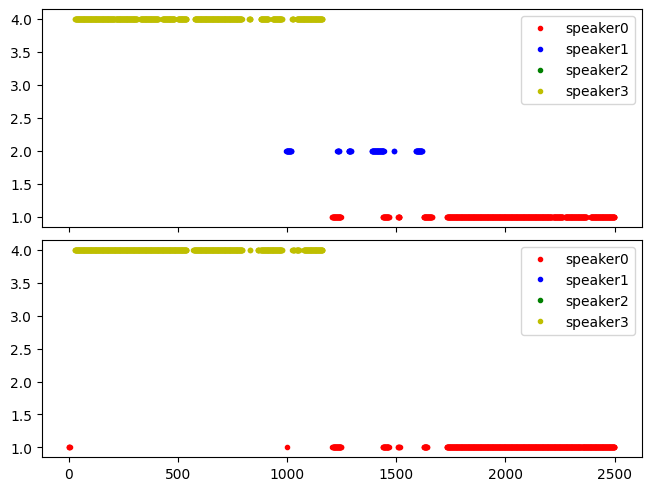

In [21]:
Y, T = data.val_dataset[1]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/1661900720.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(8.2215)


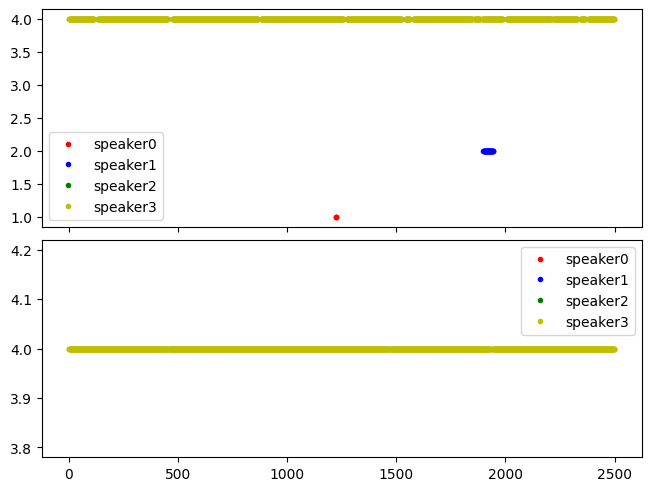

In [22]:
Y, T = data.val_dataset[2]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/909077580.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(6.8520)


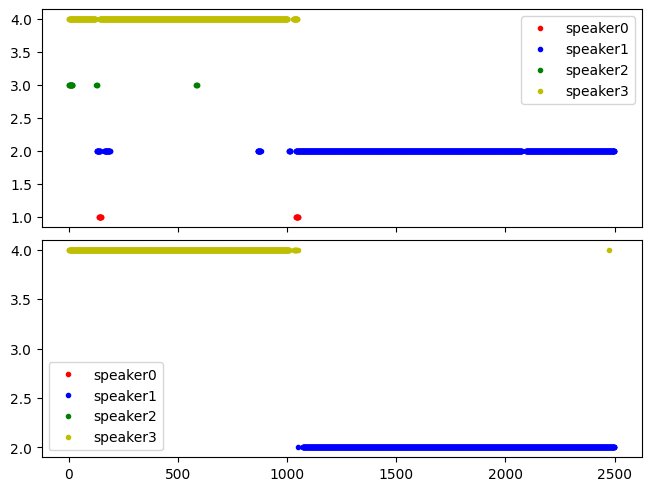

In [23]:
Y, T = data.test_dataset[3]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/2809303624.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(66.1538)


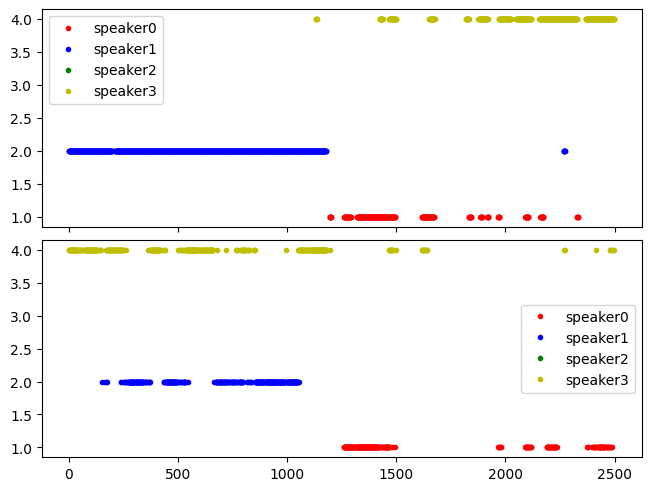

In [24]:
Y, T = data.test_dataset[4]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/690462278.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(7.6834)


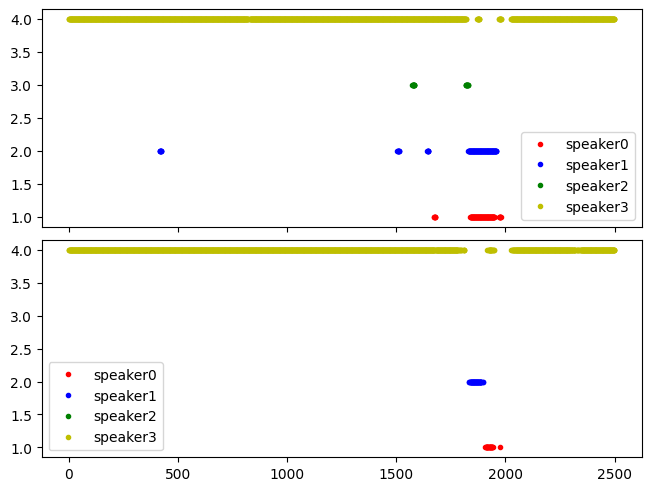

In [25]:
Y, T = data.test_dataset[5]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/2348350928.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(12.3259)


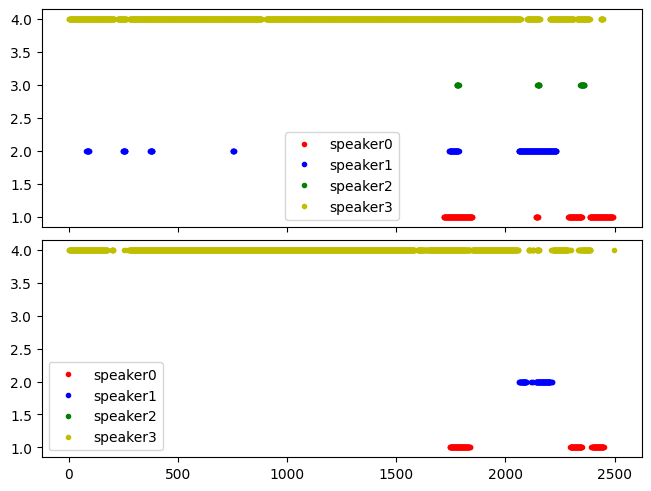

In [26]:
Y, T = data.test_dataset[6]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/3202096970.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(23.1444)


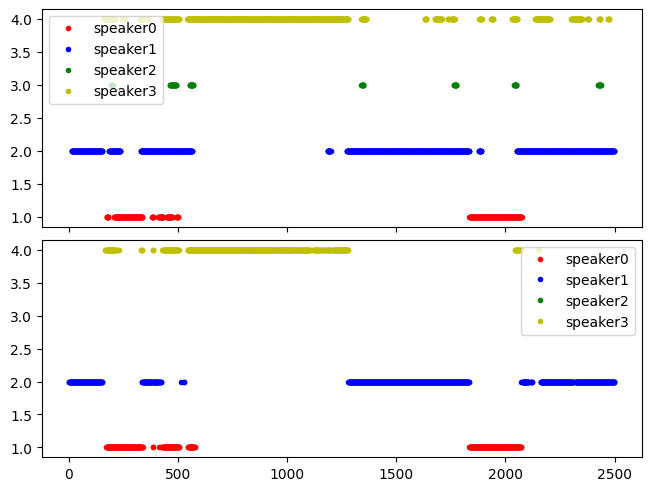

In [27]:
Y, T = data.test_dataset[7]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/1145467101.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(27.9755)


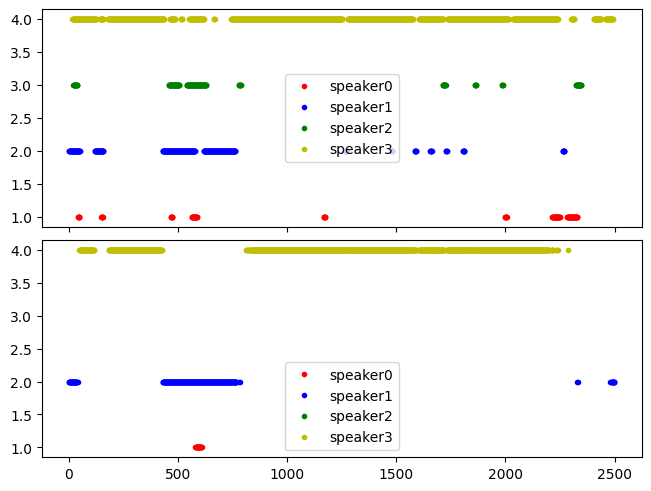

In [28]:
Y, T = data.test_dataset[8]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/2979690992.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(33.8728)


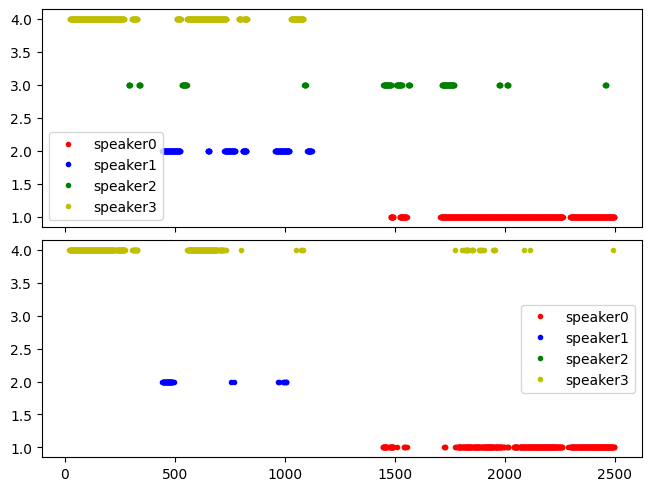

In [29]:
Y, T = data.test_dataset[9]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/1013864452.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(11.9509)


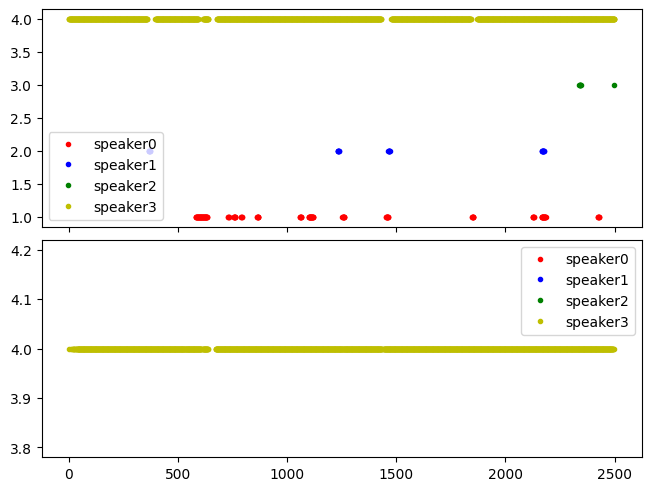

In [30]:
Y, T = data.test_dataset[10]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/3778579556.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(36.7986)


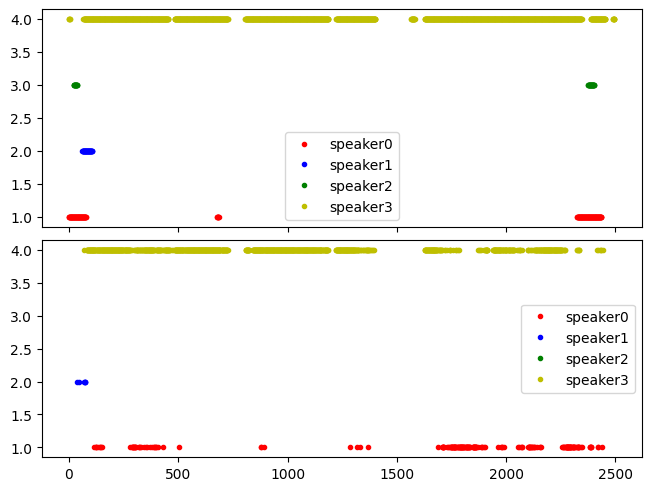

In [31]:
Y, T = data.test_dataset[11]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/3802963169.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(17.9137)


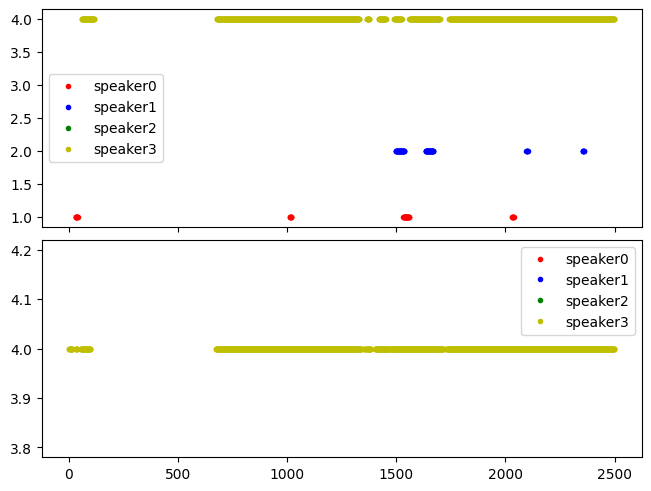

In [32]:
Y, T = data.test_dataset[12]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/252319671.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(26.6481)


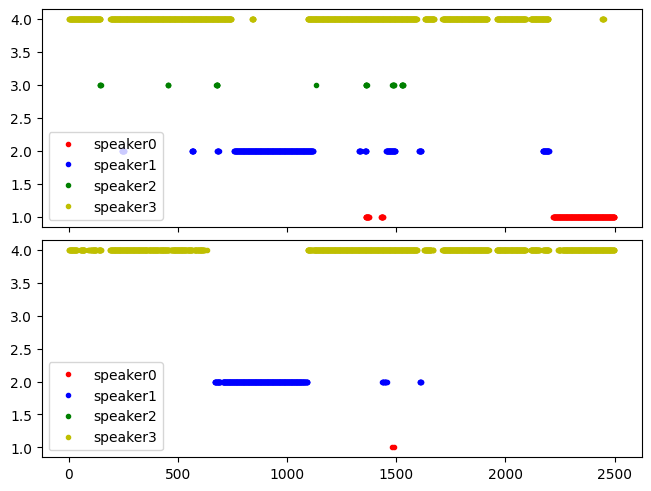

In [33]:
Y, T = data.test_dataset[13]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/3611185554.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(36.4865)


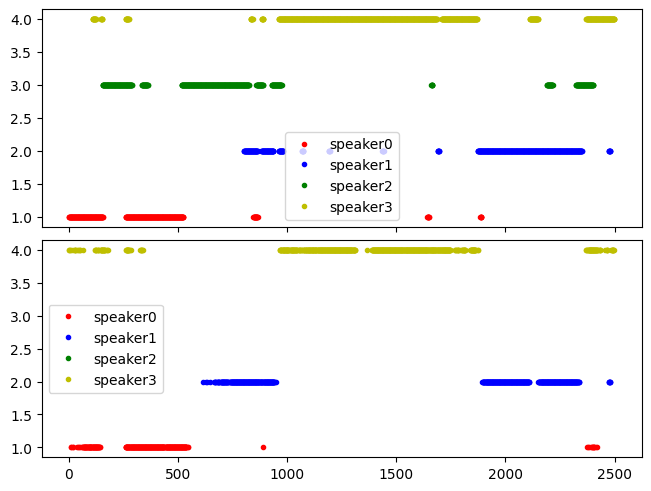

In [34]:
Y, T = data.test_dataset[14]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/2209843135.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(26.9506)


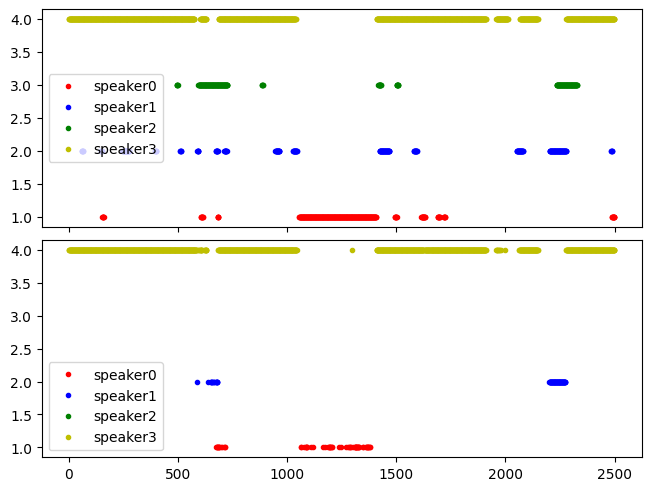

In [35]:
Y, T = data.test_dataset[15]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/1320968355.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(23.4588)


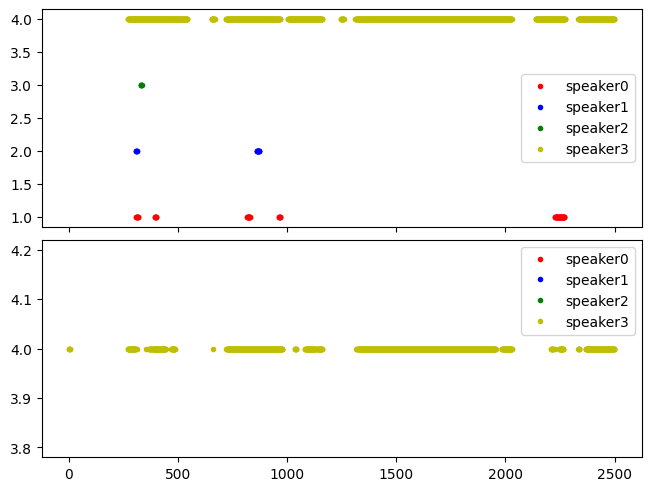

In [36]:
Y, T = data.test_dataset[16]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/3368889456.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(13.6694)


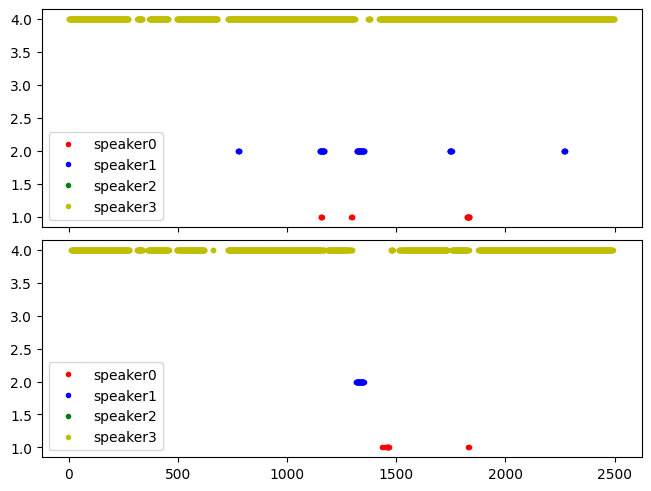

In [37]:
Y, T = data.test_dataset[17]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/3413167878.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(10.8955)


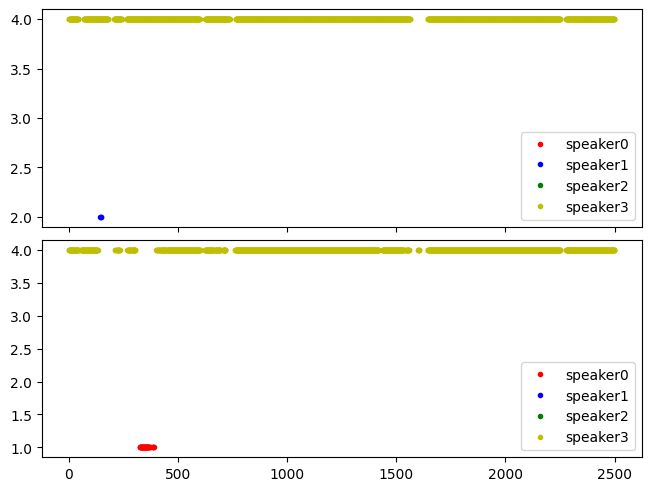

In [38]:
Y, T = data.test_dataset[18]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/4185212585.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(10.1360)


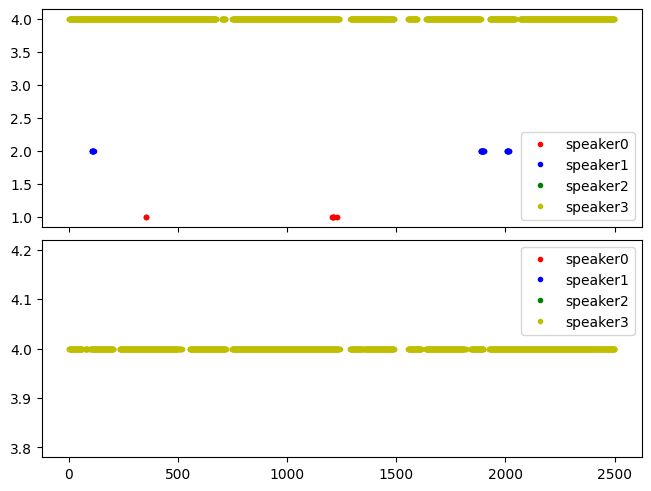

In [39]:
Y, T = data.test_dataset[19]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)

/tmp/ipykernel_23/219691375.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stats = calc_diarization_error(T_pred, torch.tensor(T))


tensor(19.8265)


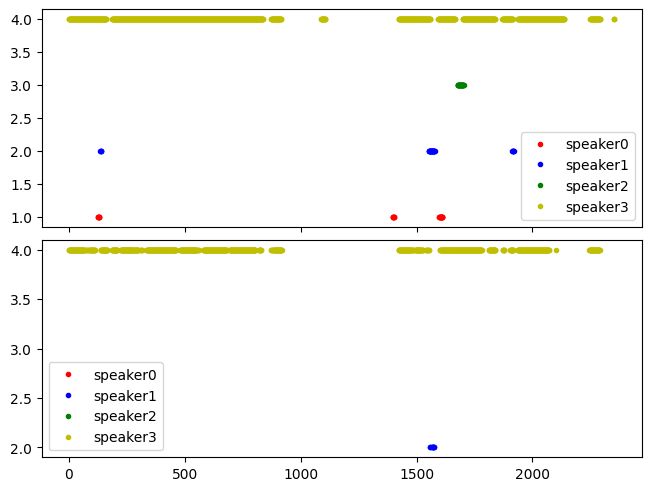

In [40]:
Y, T = data.test_dataset[20]
model.eval()
T_pred = model(torch.tensor(Y).unsqueeze(0)).squeeze(0).detach()
loss, labels = batch_pit_loss(T_pred.unsqueeze(0), torch.Tensor(T).unsqueeze(0))
T = labels[0]
T_post = torch.sigmoid(T_pred)
T_post[T_pred>0.5] = 1
T_post[T_pred<=0.5] = 0
fig, ax = plt.subplots(2, 1, sharex = True, layout='constrained')
ax[0].plot(np.arange(T[:, 0].shape[0])[T[:, 0]>0],T[:, 0][T[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[0].plot(np.arange(T[:, 1].shape[0])[T[:, 1]>0],T[:, 1][T[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[0].plot(np.arange(T[:, 2].shape[0])[T[:, 2]>0],T[:, 2][T[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[0].plot(np.arange(T[:, 3].shape[0])[T[:, 3]>0],T[:, 3][T[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[1].plot(np.arange(T_post[:, 0].shape[0])[T_post[:, 0]>0],T_post[:, 0][T_post[:, 0]>0]*1, 'r.', linewidth = 10, label = 'speaker0')
ax[1].plot(np.arange(T_post[:, 1].shape[0])[T_post[:, 1]>0],T_post[:, 1][T_post[:, 1]>0]*2, 'b.', linewidth = 10, label = 'speaker1')
ax[1].plot(np.arange(T_post[:, 2].shape[0])[T_post[:, 2]>0],T_post[:, 2][T_post[:, 2]>0]*3, 'g.', linewidth = 10, label = 'speaker2')
ax[1].plot(np.arange(T_post[:, 3].shape[0])[T_post[:, 3]>0],T_post[:, 3][T_post[:, 3]>0]*4, 'y.', linewidth = 10, label = 'speaker3')
ax[0].legend()
ax[1].legend()
stats = calc_diarization_error(T_pred, torch.tensor(T))
print(stats['diarization_error']/stats['speaker_scored']*100)